#use the vector quant to build the histgram for further classification.

In [1]:
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, roc_curve, classification_report, auc, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, StratifiedShuffleSplit

In [2]:
def get_alpha_str3(s):
    result = re.sub(r'[^A-Za-z]', '', s)
    return result

In [3]:
#read in the data
#remove those are not the data folds
work_dir = '/Users/zhoukewei/cs498/hw5/HMP_Dataset'
os.chdir(work_dir)

#try to read in the first
list = os.listdir(work_dir) # get the list file in this direction
if '.DS_Store' in list:
    list.remove('.DS_Store')
label =np.arange(0,len(list))
label_ref = list
file_fold = []
for f in list:
    file_fold.append(work_dir+'/'+f)
#file_fold list

data = pd.DataFrame(columns=['x','y','z','label','obs'])
j=0
for i in range(len(file_fold)):
    file_list = os.listdir(file_fold[i])#
    if '.DS_Store' in file_list:#remove the hidden file
        file_list.remove('.DS_Store')

    for f in file_list:
        u = f
        a=''
        b=a.join(u.split("-")[1:-1])       
        path = file_fold[i]+'/'+f
        tmp = np.loadtxt(path)
        tmp = pd.DataFrame(tmp,columns=['x','y','z'])
        tmp['label']=label_ref[j]
        tmp['obs']=b
        data = data.append(tmp)
    j= j+1



In [5]:
movement_list = data['obs'].value_counts().index.values
#len(movement_list)
len(data)/32
movement_list

array(['20110324132139eat_meat', '20110324131252eat_meat',
       '20110324131742eat_meat', '20110324130615eat_meat',
       '20110324131014eat_meat', '20110530103416brush_teeth',
       '20110411115557walk', '20110606104527brush_teeth',
       '20110530215504brush_teeth', '20110602104550brush_teeth',
       '20110329095241use_telephone', '20110530211057brush_teeth',
       '20110602104222brush_teeth', '20110531151647brush_teeth',
       '20110530082907walk', '20110606104805brush_teeth',
       '20110530102928walk', '20110324133322eat_soup',
       '20110324135642eat_soup', '20110530083511brush_teeth',
       '20110411115410use_telephone', '20110411132818brush_teeth',
       '20110530093650brush_teeth', '20110324134418eat_soup',
       '20110405183057walk', '20110530093503walk', '20110530205719walk',
       '20110530214435walk', '20110530213955walk', '20110530205103walk',
       '20110530214316use_telephone', '20110411131755drink_glass',
       '20110531145441walk', '20110324161036comb

we have 839 different obs for different posture

#create the vector quantize on x. 
then I can go with y and z

In [253]:

def vector_quant(data,obs_train,obs_test,segment_length= 32,ncluster= 480):
    movement_list = data['obs'].value_counts().index.values    
    segment = pd.DataFrame()
    for movement in movement_list:
        subdata = data.loc[data['obs']== movement,'x']
        i = int(len(subdata)/segment_length)
        df = pd.DataFrame(np.array(subdata.iloc[:segment_length*i,]).reshape((i, segment_length)))
        df['movement'] = movement
        segment = segment.append(df)

    x =segment.iloc[:,:-1]
    x_train=segment[segment['movement'].isin(obs_train)]
    
    x_train =x_train.iloc[:,:-1]
    kmeans = KMeans(n_clusters=480, random_state=0).fit(x_train)
    # kmeans.labels_
    label_vec =  kmeans.predict(x)
    segment['cluster'] = label_vec

    vec_quant_x = pd.DataFrame(0,index= movement_list,columns= np.arange(ncluster))
    vec_quant_x['movement'] = movement_list 
    for move in movement_list:
        tmp = segment.loc[segment['movement']== move,'cluster']
        for i in range(len(tmp)):
            c = tmp[i]
            vec_quant_x.loc[vec_quant_x['movement']== move,vec_quant_x.columns[c]] = 1+vec_quant_x.loc[vec_quant_x['movement']== move,vec_quant_x.columns[c]]   

    segment = pd.DataFrame()
    for movement in movement_list:
        subdata = data.loc[data['obs']== movement,'y']
        i = int(len(subdata)/segment_length)
        df = pd.DataFrame(np.array(subdata.iloc[:segment_length*i,]).reshape((i, segment_length)))
        df['movement'] = movement
        segment = segment.append(df)

    y =segment.iloc[:,:-1]
    y_train=segment[segment['movement'].isin(obs_train)]
    y_train =y_train.iloc[:,:-1]
    kmeans = KMeans(n_clusters=480, random_state=0).fit(y_train)
    # kmeans.labels_
    label_vec =  kmeans.predict(y)
    segment['cluster'] = label_vec

    vec_quant_y = pd.DataFrame(0,index= movement_list,columns= np.arange(ncluster))
    vec_quant_y['movement'] = movement_list 
    for move in movement_list:
        tmp = segment.loc[segment['movement']== move,'cluster']
        for i in range(len(tmp)):
            c = tmp[i]
            vec_quant_y.loc[vec_quant_y['movement']== move,vec_quant_y.columns[c]] = 1+vec_quant_y.loc[vec_quant_y['movement']== move,vec_quant_y.columns[c]]  

    segment = pd.DataFrame()
    for movement in movement_list:
        subdata = data.loc[data['obs']== movement,'z']
        i = int(len(subdata)/segment_length)
        df = pd.DataFrame(np.array(subdata.iloc[:segment_length*i,]).reshape((i, segment_length)))
        df['movement'] = movement
        segment = segment.append(df)

    z =segment.iloc[:,:-1]
    z_train=segment[segment['movement'].isin(obs_train)]
    z_train =z_train.iloc[:,:-1]
    kmeans = KMeans(n_clusters=480, random_state=0).fit(z_train)
    # kmeans.labels_
    label_vec =  kmeans.predict(z)
    segment['cluster'] = label_vec

    vec_quant_z = pd.DataFrame(0,index= movement_list,columns= np.arange(ncluster))
    vec_quant_z['movement'] = movement_list 
    for move in movement_list:
        tmp = segment.loc[segment['movement']== move,'cluster']
        for i in range(len(tmp)):
            c = tmp[i]
            vec_quant_z.loc[vec_quant_z['movement']== move,vec_quant_z.columns[c]] = 1+vec_quant_z.loc[vec_quant_z['movement']== move,vec_quant_z.columns[c]]            

    df = pd.merge(vec_quant_x, vec_quant_y, on='movement')
    df = pd.merge(df, vec_quant_z, on='movement')
    df['label']=df['movement']
    list = []
    for i in range(len(df['movement'])):
        list.append(get_alpha_str3(df.iloc[i,:]['label']))   
    df['label']= list 
    train = df[df['movement'].isin(obs_train)]
    test = df[df['movement'].isin(obs_test)]
    return train, test

In [254]:
train, test=vector_quant(data,obs_train,obs_test,segment_length= 32,
                         ncluster= 480)



KeyboardInterrupt: 

In [ ]:
#we can do this but I just don't want to do.
# col = train.columns
# col_feature = col[(col!= 'label')&(col!= 'movement')]
# X_train=train[col_feature]
# X_test=test[col_feature]
# y_train=train.loc[:,'label']
# y_test=test.loc[:,'label']
# labels = pd.Series(y_train).unique()


# rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
# rf.fit(X_train, y_train)
# predicted = rf.predict(X_test)
# accuracy = accuracy_score(y_test, predicted)
# print(accuracy)    
# cm = pd.DataFrame(confusion_matrix(y_test, predicted))
# sns.heatmap(cm, annot=True)
# xlocations = np.array(range(len(labels)))
# plt.xticks(xlocations, labels, rotation=90)
# plt.yticks(xlocations, labels, rotation=0)
# plt.ylabel('Index of True Classes')
# plt.xlabel('Index of Predict Classes')
# # plt.title('Confusion matrix with segment_length= %d and ncluster= %d' %(length,ncluster))
# plt.show()

In [7]:
#with xyz all for cluster #testsplit train 
def vector_quant(data,obs_train,obs_test,segment_length= 16,ncluster= 480):
    movement_list = data['obs'].value_counts().index.values    
    segment = pd.DataFrame()
    for movement in movement_list:
        subdata = data.loc[data['obs']== movement,'x']
        i = int(len(subdata)/segment_length)
        df = pd.DataFrame(np.array(subdata.iloc[:segment_length*i,]).reshape((i, segment_length)))
        df['movement'] = movement
        segment = segment.append(df)

    x =segment.iloc[:,:-1]
    segment = pd.DataFrame()
    for movement in movement_list:
        subdata = data.loc[data['obs']== movement,'y']
        i = int(len(subdata)/segment_length)
        df = pd.DataFrame(np.array(subdata.iloc[:segment_length*i,]).reshape((i, segment_length)))
        df['movement'] = movement
        segment = segment.append(df)

    y =segment.iloc[:,:-1]

    segment = pd.DataFrame()
    for movement in movement_list:
        subdata = data.loc[data['obs']== movement,'z']
        i = int(len(subdata)/segment_length)
        df = pd.DataFrame(np.array(subdata.iloc[:segment_length*i,]).reshape((i, segment_length)))
        df['movement'] = movement
        segment = segment.append(df)

    z =segment.iloc[:,:]
    frame = [x,y,z]
    segment = pd.concat(frame, axis=1)
    segment.columns
    X = segment.iloc[:,:-1]
    X_train=segment[segment['movement'].isin(obs_train)]
    X_train =X_train.iloc[:,:-1]
    kmeans = KMeans(n_clusters=ncluster, random_state=0).fit(X_train)
    # kmeans.labels_
    label_vec =  kmeans.predict(X)
    segment['cluster'] = label_vec

    vec_quant_X = pd.DataFrame(0,index= movement_list,columns= np.arange(ncluster))
    vec_quant_X['movement'] = movement_list 

    for move in movement_list:
        tmp = pd.DataFrame(segment.loc[segment['movement']== move,:])
        count = tmp['cluster'].value_counts()
        count_label= count.index.values
        count_value = count.values
        for i in range(len(count_label)):
            vec_quant_X.loc[vec_quant_X['movement']== move,vec_quant_X.columns[count_label[i]]]=count_value[i]


    df =vec_quant_X
    df['label']=df['movement']
    list = []
    for i in range(len(df['movement'])):
        list.append(get_alpha_str3(df.iloc[i,:]['label']))   
    df['label']= list 
    train = df[df['movement'].isin(obs_train)]
    test = df[df['movement'].isin(obs_test)]

    col = train.columns
    col_feature = col[(col!= 'label')&(col!= 'movement')]
    X_train=train[col_feature]
    X_test=test[col_feature]
    y_train=train.loc[:,'label']
    y_test=test.loc[:,'label']
    labels = pd.Series(y_train).unique()
    return train, test

In [123]:


#with xyz all for cluster #testsplit train 
def vector_quant_overlap(data,obs_train,obs_test,segment_length= 16,ncluster= 480,overlap = 0.75):
    movement_list = data['obs'].value_counts().index.values    
    segment = pd.DataFrame()    
    for movement in movement_list:
        subdata = data.loc[data['obs']== movement,'x']
        df = pd.DataFrame()
        u = int((segment_length*(1-overlap)))
        for i in range(  int(  (len(subdata)-segment_length)/u  )-1):
            t = pd.DataFrame(subdata[i*u:i*u+segment_length])
            t = pd.DataFrame(np.array(t).reshape((1, segment_length)),columns = range(segment_length))
            df = df.append(t)
        df['movement'] = movement
        segment = segment.append(df)
    x =segment.iloc[:,:-1]
    segment = pd.DataFrame()
    for movement in movement_list:
        subdata = data.loc[data['obs']== movement,'y']
        df = pd.DataFrame()
        u = int((segment_length*(1-overlap)))
        for i in range(  int(  (len(subdata)-segment_length)  /u  )-1):
            t = pd.DataFrame(subdata[i*u:i*u+segment_length])
            t = pd.DataFrame(np.array(t).reshape((1, segment_length)),columns = range(segment_length))
            df = df.append(t)
        df['movement'] = movement
        segment = segment.append(df)
    y =segment.iloc[:,:-1]
    segment = pd.DataFrame()
    for movement in movement_list:
        subdata = data.loc[data['obs']== movement,'z']
        df = pd.DataFrame()
        u = int((segment_length*(1-overlap)))
        for i in range(  int(  (len(subdata)-segment_length)  /u  )-1):
            t = pd.DataFrame(subdata[i*u:i*u+segment_length])
            t = pd.DataFrame(np.array(t).reshape((1, segment_length)),columns = range(segment_length))
            df = df.append(t)
        df['movement'] = movement
        segment = segment.append(df)
    z =segment.iloc[:,:]
    frame = [x,y,z]
    segment = pd.concat(frame, axis=1)
    segment.columns
    X = segment.iloc[:,:-1]
    X_train=segment[segment['movement'].isin(obs_train)]
    X_train =X_train.iloc[:,:-1]
    kmeans = KMeans(n_clusters=ncluster, random_state=0).fit(X_train)
    # kmeans.labels_
    label_vec =  kmeans.predict(X)
    segment['cluster'] = label_vec
    vec_quant_X = pd.DataFrame(0,index= movement_list,columns= np.arange(ncluster))
    vec_quant_X['movement'] = movement_list 

    for move in movement_list:
        tmp = pd.DataFrame(segment.loc[segment['movement']== move,:])
        count = tmp['cluster'].value_counts()
        count_label= count.index.values
        count_value = count.values
        for i in range(len(count_label)):
            vec_quant_X.loc[vec_quant_X['movement']== move,vec_quant_X.columns[count_label[i]]]=count_value[i]
    df =vec_quant_X
    df['label']=df['movement']
    list = []
    for i in range(len(df['movement'])):
        list.append(get_alpha_str3(df.iloc[i,:]['label']))   
    df['label']= list 
    train = df[df['movement'].isin(obs_train)]
    test = df[df['movement'].isin(obs_test)]
    col = train.columns
    col_feature = col[(col!= 'label')&(col!= 'movement')]
    X_train=train[col_feature]
    X_test=test[col_feature]
    y_train=train.loc[:,'label']
    y_test=test.loc[:,'label']
    labels = pd.Series(y_train).unique()
    return train, test



In [10]:
#get the movement_list for the train and test split
tmp=data.groupby(data['obs']).first()

ftrain, ftest, ytrain, ytest =\
    train_test_split(tmp['x'], tmp['label'], test_size=0.3, stratify=  tmp['label'], random_state=123456)


ytrain.value_counts()
ytest.head
obs_train = ytrain.index.values
obs_test = ytest.index.values

0.746031746032


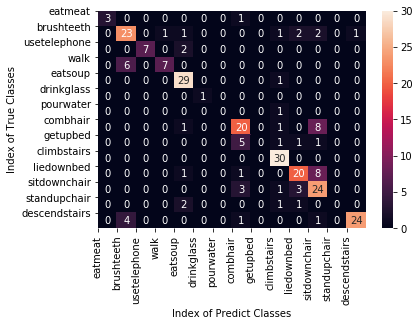

175.2527632713318

In [57]:
import time
s = time.time()
train, test=vector_quant(data,obs_train,obs_test,segment_length= 16,ncluster= 480)

col = train.columns
col_feature = col[(col!= 'label')&(col!= 'movement')]
X_train=train[col_feature]
X_test=test[col_feature]
y_train=train.loc[:,'label']
y_test=test.loc[:,'label']
labels = pd.Series(y_train).unique()
rf = RandomForestClassifier(n_estimators=500,  random_state=123456)
rf.fit(X_train, y_train)
predicted = rf.predict(X_test)›
accuracy = accuracy_score(y_test, predicted)
print(accuracy)    
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
sns.heatmap(cm, annot=True)
xlocations = np.array(range(len(labels)))
plt.xticks(xlocations, labels, rotation=90)›
plt.yticks(xlocations, labels, rotation=0)
plt.ylabel('Index of True Classes')
plt.xlabel('Index of Predict Classes')
# plt.title('Confusion matrix with segment_length= %d and ncluster= %d' %(length,ncluster))
plt.show()
e = time.time()
e-s

In [112]:
len_list =[12,16,24,32]
ncluster_list=np.arange(320,560,160)
overlap_list = np.arange(0.25,1,0.25)
accuracy_rf_list = []
accuracy_knn_list= []
for length in len_list:
    for ncluster in ncluster_list:
        for overlap in overlap_list:
            s = time.time()
            train, test=vector_quant_overlap(data,obs_train,obs_test,segment_length= 16,ncluster= 480,overlap = overlap)
            col = train.columns
            col_feature = col[(col!= 'label')&(col!= 'movement')]
            X_train=train[col_feature]
            X_test=test[col_feature]
            y_train=train.loc[:,'label']
            y_test=test.loc[:,'label']
            labels = pd.Series(y_train).unique()
            rf = RandomForestClassifier(n_estimators=500,  random_state=123456)
            rf.fit(X_train, y_train)
            predicted = rf.predict(X_test)
            accuracy = accuracy_score(y_test, predicted)
            accuracy_rf_list.append(accuracy)
            print(accuracy)    
            cm = pd.DataFrame(confusion_matrix(y_test, predicted))
            sns.heatmap(cm, annot=True)
            xlocations = np.array(range(len(labels)))
            plt.xticks(xlocations, labels, rotation=90)
            plt.yticks(xlocations, labels, rotation=0)
            plt.ylabel('Index of True Classes')
            plt.xlabel('Index of Predict Classes')
            
            plt.title('Confusion matrix with segment_length= %d  ncluster= %d and overlap = %s ,' %(length,ncluster,overlap))
            
            
            plt.show()
            
            knn = KNeighborsClassifier()
            knn.fit(X_train, y_train)
            predicted = knn.predict(X_test)
            accuracy = accuracy_score(y_test, predicted)
            accuracy_knn_list.append(accuracy)
            print('The accuracy of knn is %s' %(accuracy))
            e = time.time()
            print(e-s)
accuracy_rf_list

KeyboardInterrupt: 

0.833333333333


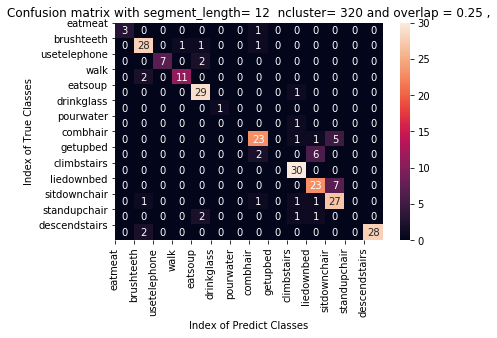

The accuracy of knn is 0.571428571429
1092.5249199867249


In [124]:
#after check the frip of parameters, I choose segment length 16,k = 480 ,
# overlap = 0.75
s = time.time()
train, test=vector_quant_overlap(data,obs_train,obs_test)
col = train.columns
col_feature = col[(col!= 'label')&(col!= 'movement')]
X_train=train[col_feature]
X_test=test[col_feature]
y_train=train.loc[:,'label']
y_test=test.loc[:,'label']
labels = pd.Series(y_train).unique()
rf = RandomForestClassifier(n_estimators=500,  random_state=123456)
rf.fit(X_train, y_train)
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
accuracy_rf_list.append(accuracy)
print(accuracy)    
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
sns.heatmap(cm, annot=True)
xlocations = np.array(range(len(labels)))
plt.xticks(xlocations, labels, rotation=90)
plt.yticks(xlocations, labels, rotation=0)
plt.ylabel('Index of True Classes')
plt.xlabel('Index of Predict Classes')

plt.title('Confusion matrix with segment_length= %d  ncluster= %d and overlap = %s ,' %(length,ncluster,overlap))


plt.show()

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predicted = knn.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
accuracy_knn_list.append(accuracy)
print('The accuracy of knn is %s' %(accuracy))
e = time.time()
print(e-s)

In [184]:
mean_vec.iloc[1]

0      0.140845
1      0.028169
2      0.028169
3      0.042254
4      0.056338
5      0.000000
6      0.000000
7      0.661972
8      0.000000
9      0.000000
10     0.323944
11     0.943662
12     0.436620
13     0.000000
14     0.183099
15     0.028169
16     0.084507
17     0.056338
18     0.000000
19     0.112676
20     0.000000
21     0.000000
22     0.042254
23     0.112676
24     0.000000
25     0.014085
26     0.084507
27     0.028169
28     0.014085
29     1.225352
         ...   
450    0.056338
451    0.169014
452    0.000000
453    0.000000
454    0.000000
455    0.042254
456    0.000000
457    0.000000
458    0.000000
459    0.014085
460    0.112676
461    0.098592
462    0.014085
463    1.577465
464    0.098592
465    0.000000
466    0.042254
467    0.309859
468    2.577465
469    0.239437
470    0.000000
471    0.000000
472    0.000000
473    0.000000
474    0.112676
475    0.000000
476    0.197183
477    2.873239
478    0.577465
479    0.521127
Name: climbstairs, Lengt

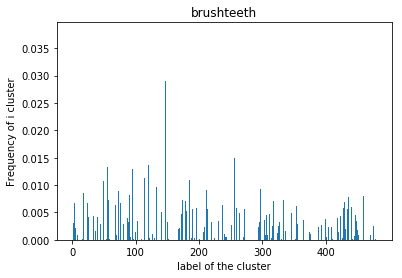

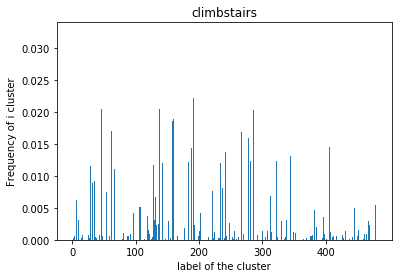

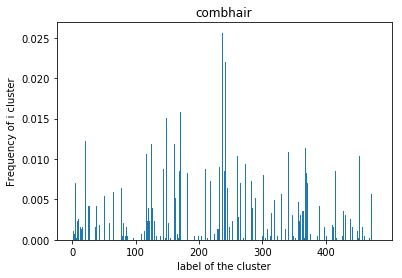

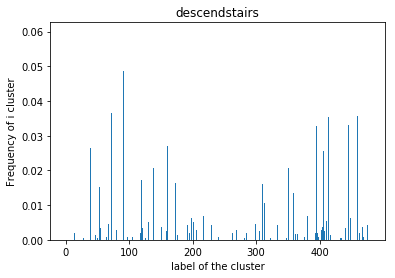

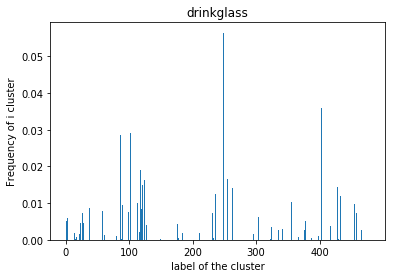

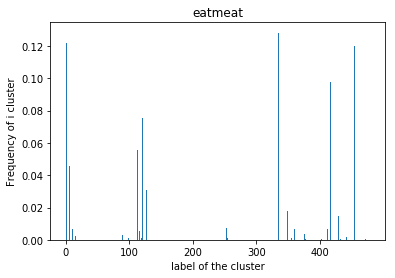

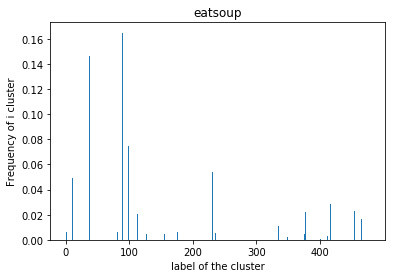

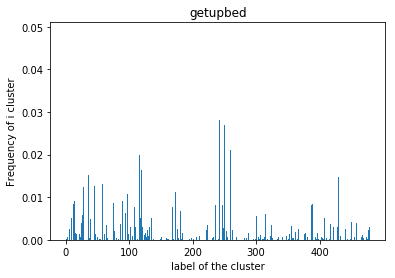

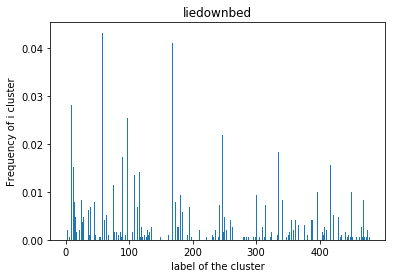

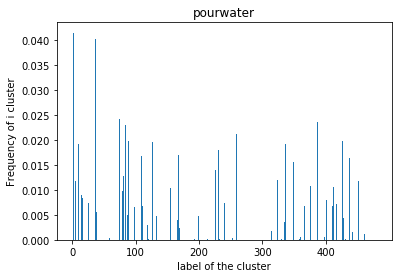

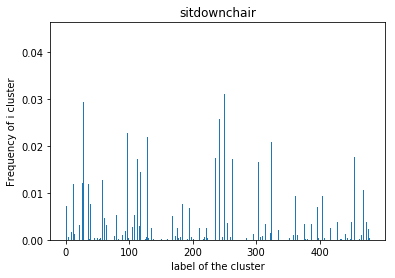

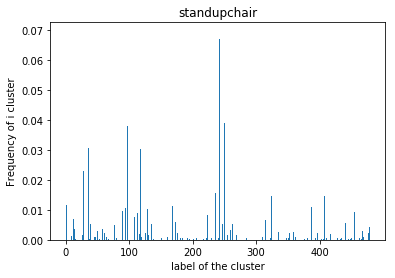

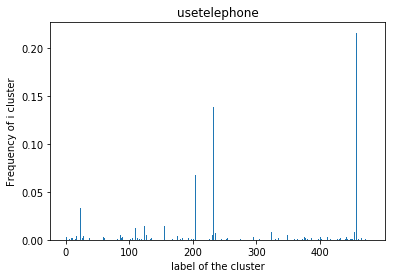

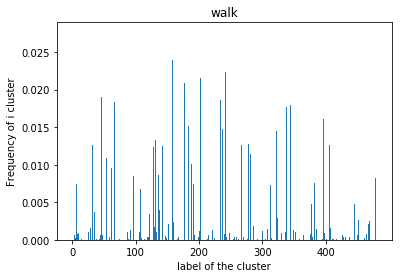

In [187]:
mean_vec = train.groupby('label').mean()
for i in range(len(mean_vec)):
    x = mean_vec.iloc[i]
    
    plt.bar(range(480),x/sum(x))
    plt.xticks(np.arange(0, 480, step=100))
    plt.ylabel('Frequency of i cluster')
    plt.xlabel('label of the cluster')
    plt.title('%s' %(mean_vec.index.values[i]))
    plt.show()
    


In [165]:
x

,0,1,2,3,4,5,6,7,8,9,...,470,471,472,473,474,475,476,477,478,479
label,,,,,,,,,,,,,,,,,,,,,
brushteeth,0.0,0.0,2.125,0.0,4.5,1.5,0.0,0.0,0.625,3.625,...,0.625,0.0,0.0,0.0,0.0,1.75,0.0,0.0,0.125,0.125


The accuracy of rf is 0


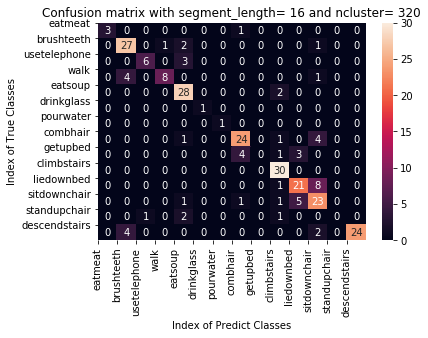

The accuracy of knn is 0
143.80316710472107
The accuracy of rf is 0


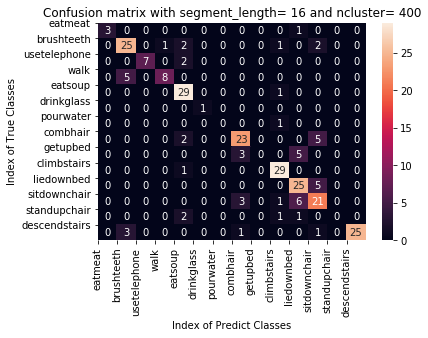

The accuracy of knn is 0
154.77596187591553
The accuracy of rf is 0


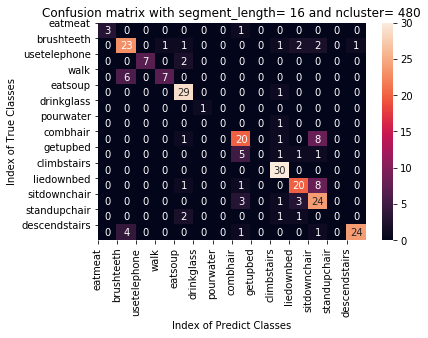

The accuracy of knn is 0
161.94911003112793
The accuracy of rf is 0


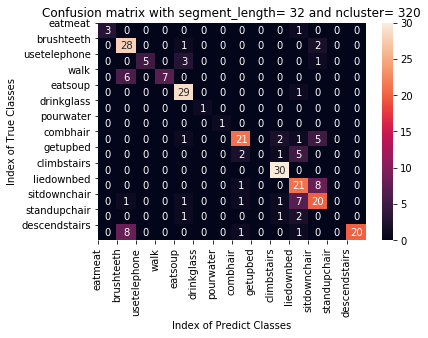

The accuracy of knn is 0
114.74498200416565
The accuracy of rf is 0


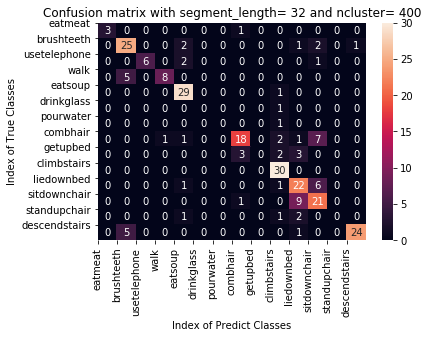

The accuracy of knn is 0
121.73086476325989
The accuracy of rf is 0


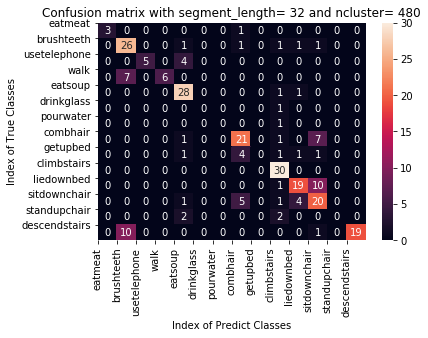

The accuracy of knn is 0
126.49342679977417


In [12]:
#without overlapping
accuracy_rf_list = []
accuracy_knn_list= []
len_list =np.arange(16,48,16)
ncluster_list=np.arange(320,560,80)

for length in len_list:
    for ncluster in ncluster_list:
        start = time.time()
        train, test=vector_quant(data,obs_train,obs_test,segment_length= length,ncluster= ncluster)

        col = train.columns
        col_feature = col[(col!= 'label')&(col!= 'movement')]
        X_train=train[col_feature]
        X_test=test[col_feature]
        y_train=train.loc[:,'label']
        y_test=test.loc[:,'label']
        labels = pd.Series(y_train).unique()
        rf = RandomForestClassifier(n_estimators=500,  random_state=123456)
        rf.fit(X_train, y_train)
        predicted = rf.predict(X_test)
        accuracy = accuracy_score(y_test, predicted)
        accuracy_rf_list.append(accuracy)
        print('The accuracy of rf is %s' %(accuracy))    
        cm = pd.DataFrame(confusion_matrix(y_test, predicted))
        sns.heatmap(cm, annot=True)
        xlocations = np.array(range(len(labels)))
        plt.xticks(xlocations, labels, rotation=90)
        plt.yticks(xlocations, labels, rotation=0)
        plt.ylabel('Index of True Classes')
        plt.xlabel('Index of Predict Classes')
        plt.title('Confusion matrix with segment_length= %d and ncluster= %d' %(length,ncluster))
        plt.show()
        knn = KNeighborsClassifier()
        knn.fit(X_train, y_train)
        predicted = knn.predict(X_test)
        accuracy = accuracy_score(y_test, predicted)
        accuracy_knn_list.append(accuracy)
        print('The accuracy of knn is %s' %(accuracy))    
        end = time.time()
        print(end - start)




In [191]:
test['label'].value_counts()

standupchair     31
climbstairs      31
walk             30
getupbed         30
sitdownchair     30
pourwater        30
drinkglass       30
descendstairs    13
combhair          9
liedownbed        8
brushteeth        4
usetelephone      4
eatmeat           1
eatsoup           1
Name: label, dtype: int64

0.84126984127


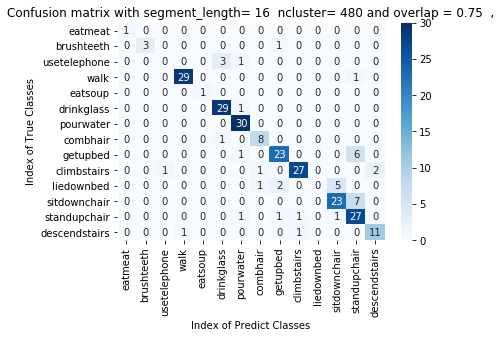

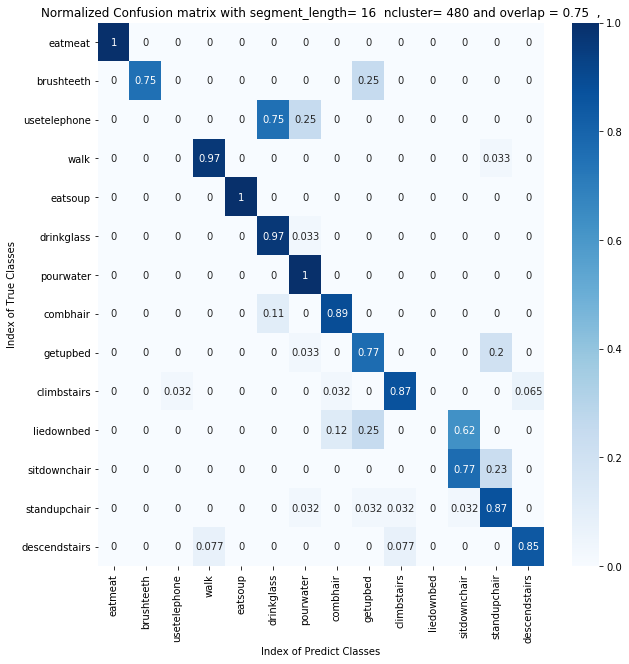

In [243]:
col = train.columns
col_feature = col[(col!= 'label')&(col!= 'movement')]
X_train=train[col_feature]
X_test=test[col_feature]
y_train=train.loc[:,'label']
y_test=test.loc[:,'label']
labels = pd.Series(y_train).unique()
rf = RandomForestClassifier(n_estimators=500,max_depth =200, class_weight='balanced',random_state=13456)
rf.fit(X_train, y_train)
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
accuracy_rf_list.append(accuracy)
print(accuracy)    
cm = confusion_matrix(y_test, predicted, labels = labels)
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues)
xlocations = np.array(range(len(labels)))+0.5
plt.xticks(xlocations, labels, rotation=90)
plt.yticks(xlocations, labels, rotation=0)
plt.ylabel('Index of True Classes')
plt.xlabel('Index of Predict Classes')
plt.title('Confusion matrix with segment_length= %d  ncluster= %d and overlap = %s  ,' %(16,480,0.75))
plt.show()
plt.figure(figsize=(10,10))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True,cmap=plt.cm.Blues)
xlocations = np.array(range(len(labels)))+0.5
plt.xticks(xlocations, labels, rotation=90)
plt.yticks(xlocations, labels, rotation=0)
plt.ylabel('Index of True Classes')
plt.xlabel('Index of Predict Classes')
plt.title('Normalized Confusion matrix with segment_length= %d  ncluster= %d and overlap = %s  ,' %(16,480,0.75))
plt.show()

In [222]:
xlocations+0.5

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.])

In [195]:
overlap

0.25

In [194]:
ncluster

320

In [196]:
y_test.value_counts()

standupchair     31
climbstairs      31
walk             30
getupbed         30
sitdownchair     30
pourwater        30
drinkglass       30
descendstairs    13
combhair          9
liedownbed        8
brushteeth        4
usetelephone      4
eatmeat           1
eatsoup           1
Name: label, dtype: int64

In [197]:
y_train.value_counts()

standupchair     71
getupbed         71
climbstairs      71
sitdownchair     70
drinkglass       70
walk             70
pourwater        70
descendstairs    29
combhair         22
liedownbed       20
usetelephone      9
brushteeth        8
eatmeat           4
eatsoup           2
Name: label, dtype: int64

In [200]:
predicted[:10]

array(['eatmeat', 'walk', 'brushteeth', 'brushteeth', 'walk', 'pourwater',
       'drinkglass', 'brushteeth', 'walk', 'drinkglass'], dtype=object)

In [202]:
confusion_matrix(y_test, predicted)


array([[ 3,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  1,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  7,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 29,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 23,  0,  1,  1,  5,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  6,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 30,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 23,  7,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  1,  0,  1,  1, 27,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  1,  1,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 28]])

In [203]:
pd.DataFrame(confusion_matrix(y_test, predicted))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,3,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,28,0,1,1,0,0,1,0,0,0,0,0,0
2,0,0,7,0,2,0,0,0,0,0,0,0,0,0
3,0,2,0,11,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,29,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,23,0,1,1,5,0,0
8,0,0,0,0,0,0,0,2,0,0,6,0,0,0
9,0,0,0,0,0,0,0,0,0,30,0,0,0,0
